# Embedding and GPU acceleration

This tutorial demonstrates how to train an embedding network to extract informative features from observations and use these features for neural posterior estimation. Training and inference are performed on GPU.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import zuko

from tqdm import tqdm

from lampe.data import JointLoader, H5Dataset
from lampe.diagnostics import expected_coverage_mc
from lampe.inference import NPE, NPELoss
from lampe.plots import nice_rc, corner, mark_point, coverage_plot
from lampe.utils import GDStep

## Simulator

For this tutorial we use a simulator that procedurally generates distorted [Worley noise](https://wikipedia.org/wiki/Worley_noise) images with respect to three parameters.

theta: [41.51055145263672, 0.21925213932991028, 1.9552865028381348]
x:


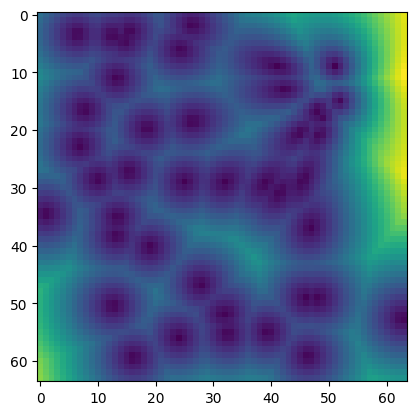

In [2]:
LABELS = [r'$\lambda$', r'$\sigma$', r'$p$']
LOWER = torch.tensor([10.0, 0.1, 1.0])
UPPER = torch.tensor([50.0, 0.5, 2.0])

prior = zuko.distributions.BoxUniform(LOWER, UPPER)

class WorleyNoise:
    def __init__(self):
        self.domain = torch.cartesian_prod(
            torch.linspace(0, 1, 64),
            torch.linspace(0, 1, 64),
        )
    
    def __call__(self, theta: torch.Tensor) -> torch.Tensor:
        lmbda, sigma, p = theta

        mu = torch.rand(2)
        cores = torch.rand(np.random.poisson(lmbda), 2)
        
        # Distortion
        x = self.domain
        x = x + torch.exp(-(x - mu).square().sum(dim=-1, keepdim=True) / sigma**2) * (x - mu)
        
        # Cells
        x = torch.cdist(x, cores, p=p)
        x = torch.min(x, dim=-1).values
        x = x / x.max()

        return x.reshape(64, 64)

simulator = WorleyNoise()

theta = prior.sample()
x = simulator(theta)

print('theta:', theta.tolist())
print('x:')

plt.imshow(x)
plt.show()

## Datasets

We store (on disk) $2^{16}$ pairs $(\theta, x) \sim p(\theta, x)$ for training, $2^{12}$ pairs for validation and $2^{10}$ pairs for testing.

In [3]:
loader = JointLoader(prior, simulator, batch_size=2**4, vectorized=False)

H5Dataset.store(loader, 'train.h5', size=2**16, overwrite=True)
H5Dataset.store(loader, 'valid.h5', size=2**12, overwrite=True)
H5Dataset.store(loader, 'test.h5', size=2**10, overwrite=True)

trainset = H5Dataset('train.h5', batch_size=256, shuffle=True)
validset = H5Dataset('valid.h5', batch_size=256)
testset = H5Dataset('test.h5')

100%|██████████| 1024/1024 [00:05<00:00, 192.07pair/s]


## Architecture

Because the observations are images, they cannot be fed directly to a `NPE` module, which only accepts vector-shaped observations. Instead, we rely on a convolutional neural network to extract a vector of informative features from the observation and feed this vector to the density estimator. In our case, the latter is a [neural spline flow](https://arxiv.org/abs/1906.04032) (NSF) with rational-quadratic splines borrowed from the [`zuko`](https://francois-rozet.github.io/zuko) package. Additionally, the parameters are standardized to the $[-1, 1]$ interval, which improves convergence.

In [4]:
class ResBlock(nn.Sequential):
    def __init__(self, features: int):
        super().__init__(
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(features, features, kernel_size=3, padding=1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + super().forward(x)

class NPEWithEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        
        mu, sigma = (LOWER + UPPER) / 2, (UPPER - LOWER) / 2  # standardization of the parameters
        
        self.npe = NPE(3, 8, moments=(mu, sigma), build=zuko.flows.NSF, hidden_features=[128] * 3, activation=nn.ELU)
        self.embedding = nn.Sequential(
            nn.Unflatten(-2, (1, 64)),
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            ResBlock(16),
            ResBlock(16),
            nn.AvgPool2d(2, 2),
            ResBlock(16),
            ResBlock(16),
            nn.AvgPool2d(2, 2),
            ResBlock(16),
            ResBlock(16),
            nn.AvgPool2d(2, 2),
            ResBlock(16),
            ResBlock(16),
            nn.AvgPool2d(2, 2),
            ResBlock(16),
            ResBlock(16),
            nn.AvgPool2d(2, 2),
            nn.Flatten(-3),
            nn.Linear(16 * 2 * 2, 8),
        )

    def forward(self, theta: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        return self.npe(theta, self.embedding(x))

    def flow(self, x: torch.Tensor):  # -> Distribution
        return self.npe.flow(self.embedding(x))

## Training

Using an embedding with `NPE` does not impact the training routine. Here, we choose to monitor the loss of the estimator on a validation set distinct from the training set, which could help detect overfitting. The training is performed on GPU, requiring to transfer batches to GPU before each step.

In [5]:
estimator = NPEWithEmbedding().cuda()
loss = NPELoss(estimator)
optimizer = optim.AdamW(estimator.parameters(), lr=1e-3)
step = GDStep(optimizer, clip=1.0)

with tqdm(range(32), unit='epoch') as tq:
    for epoch in tq:
        estimator.train()

        losses = torch.stack([
            step(loss(theta.cuda(), x.cuda()))
            for theta, x in trainset
        ])

        estimator.eval()

        with torch.no_grad():
            val_losses = torch.stack([
                loss(theta.cuda(), x.cuda())
                for theta, x in validset
            ])

        tq.set_postfix(loss=losses.mean().item(), val_loss=val_losses.mean().item())

100%|██████████| 32/32 [11:56<00:00, 22.38s/epoch, loss=-2.95, val_loss=-3.08]


## Inference

In [6]:
theta_star, x_star = testset[0]

with torch.no_grad():
    samples = estimator.flow(x_star.cuda()).sample((2**16,)).cpu()

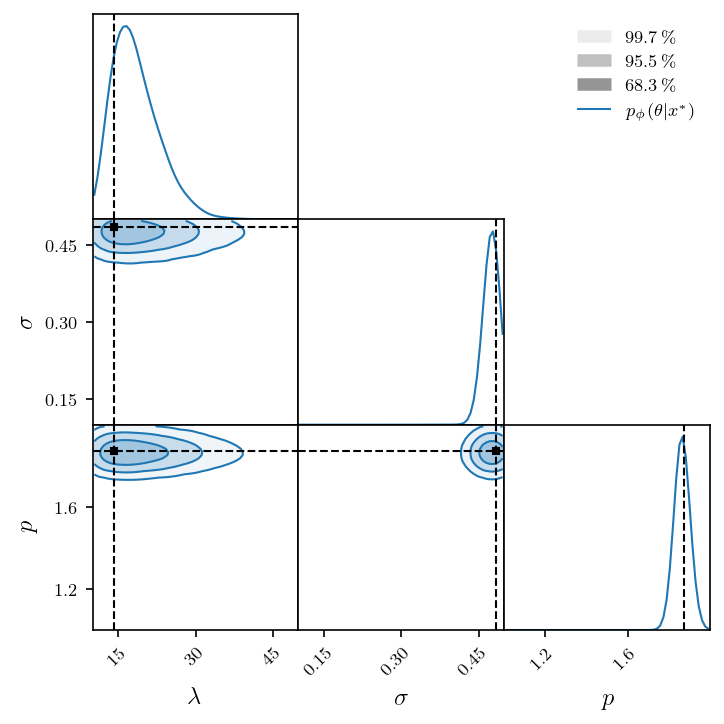

In [7]:
plt.rcParams.update(nice_rc(latex=True))  # nicer plot settings

fig = corner(
    samples,
    smooth=2,
    domain=(LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

mark_point(fig, theta_star)

## Expected coverage

1024pair [00:33, 30.72pair/s]


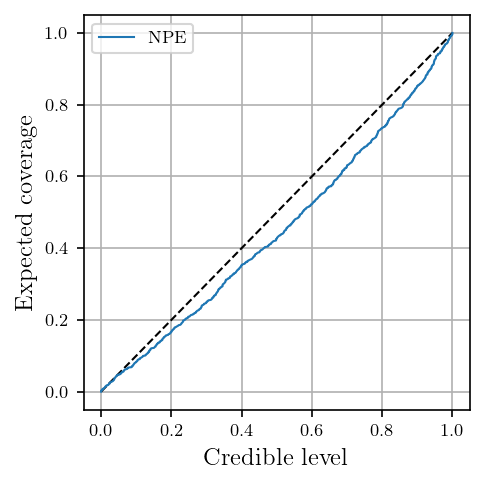

In [8]:
levels, coverages = expected_coverage_mc(
    estimator.flow,
    ((theta.cuda(), x.cuda()) for theta, x in testset),
)

fig = coverage_plot(levels, coverages, legend='NPE')

We notice that the estimator is slightly overconfident, meaning that the nominal parameters don't fall in the predicted credible regions often enough. This problem could be mitigated with more training data.